In [2]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.metrics import pairwise
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
import pandas as pd
from sklearn import preprocessing

In [3]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [4]:
n_features = 500

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [2000])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [2000])

data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Lineal vs. Non-Lineal

In [5]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear'):
    data.kernel = kernel
    with Pool(6) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores)

In [5]:
#RANDOM_SELECTION()
#RANDOM_SELECTION(kernel='linear')

#data.kernel_matrix = 'poly'
#RANDOM_SELECTION(kernel='precomputed')

#data.kernel_matrix = None
#RANDOM_SELECTION(kernel='poly')

# SVM

In [6]:
@time_func
def SVM_RFE_W_STEP(step, C = 0.5, degree = 3, kernel = 'linear', gamma = 0.1, sampling_p = 0.5, dstep_p = 0.1, dstop = 1, w1 = [0.8, 0.2]):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = C
    data.degree = degree
    data.sampling_percentagee = sampling_p
    data.dstep_percentage = dstep_p
    data.dstop = dstop
    data.gamma = gamma
    kf = KFold(n_splits=6, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_combo, index)

    #scores = list(map(data.svm_rfe_combo, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    print(kernel, degree, gamma, C)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time
    

In [7]:
@time_func
def SVM_RFE_W_STEP_ORIGIN(step, C = 0.5, degree = 3, kernel = 'linear', w1 = [0.8, 0.2]):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = C
    data.degree = degree
    kf = KFold(n_splits=6, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_kernel, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    print(kernel, degree, C)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time

In [8]:
#SVM_RFE_W_STEP(20, 0.5, 6, 'poly', sampling_p=0.5, dstep_p=0.08, dstop = 30)

In [9]:
#SVM_RFE_W_STEP(20, 0.5, 6, 'poly', sampling_p=1.0, dstep_p=0.08, dstop = 30)

In [10]:
#SVM_RFE_W_STEP(20, 0.6, 5, 'poly', sampling_p=0.5, dstep_p=0.08, dstop = 30)

In [11]:
#SVM_RFE_W_STEP(20, 0.9, 5, 'poly', sampling_p=0.5, dstep_p=0.08, dstop = 30)

In [12]:
#SVM_RFE_W_STEP(20, 0.1, kernel = 'rbf', gamma=0.025, sampling_p=0.5, dstep_p=0.1, dstop = 30)

In [13]:
#SVM_RFE_W_STEP_ORIGIN(20, 0.5, 6, 'poly')

poly 1 0.1


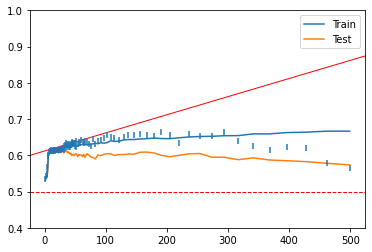

AT (8, 0.6159917402432372, 0.31040660780541024) WITH 91 ITERATIONS IN 178.01038654645285 SECONDS : 43.57672825619153
__main__.SVM_RFE_W_STEP - 00:03:17.305716600
poly 1 0.2


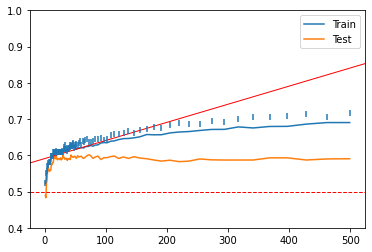

AT (16, 0.5990001978025931, 0.3271998417579256) WITH 91 ITERATIONS IN 171.4796255429586 SECONDS : 34.14786575878521
__main__.SVM_RFE_W_STEP - 00:03:08.648323800
poly 1 0.3


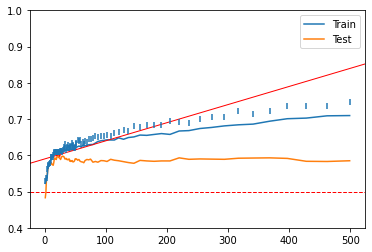

AT (22, 0.6010246773719827, 0.3279802581024138) WITH 91 ITERATIONS IN 169.19815731048584 SECONDS : 41.89543423692961
__main__.SVM_RFE_W_STEP - 00:03:08.446104200
poly 1 0.4


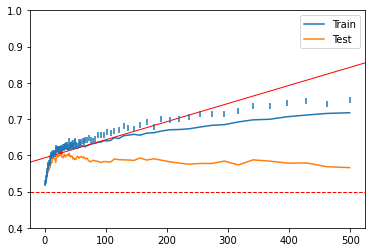

AT (25, 0.605502208795622, 0.32559823296350243) WITH 91 ITERATIONS IN 168.88472803433737 SECONDS : 38.87965664837387
__main__.SVM_RFE_W_STEP - 00:03:06.937610500
poly 1 0.5


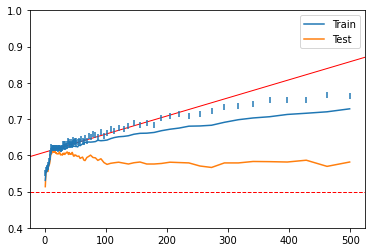

AT (13, 0.6150162138186089, 0.31318702894511286) WITH 91 ITERATIONS IN 168.30393739541373 SECONDS : 26.374429421991398
__main__.SVM_RFE_W_STEP - 00:03:05.828805900
poly 1 0.6


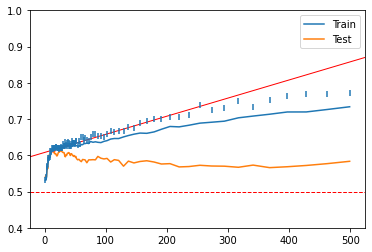

AT (13, 0.6144992297686908, 0.3136006161850474) WITH 91 ITERATIONS IN 166.45663984616598 SECONDS : 72.2550444797861
__main__.SVM_RFE_W_STEP - 00:03:07.345125500
poly 1 0.7


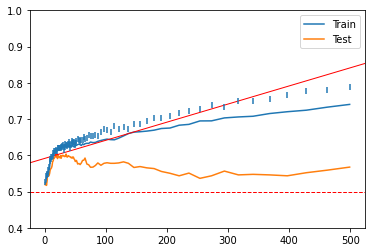

AT (19, 0.6009692327057596, 0.3268246138353923) WITH 91 ITERATIONS IN 163.78361038366953 SECONDS : 62.70129693837763
__main__.SVM_RFE_W_STEP - 00:03:04.258527300
poly 1 0.8


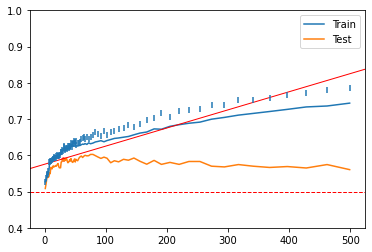

AT (30, 0.5904707102311894, 0.33962343181504856) WITH 91 ITERATIONS IN 161.78854886690775 SECONDS : 47.26827668413663
__main__.SVM_RFE_W_STEP - 00:03:01.535804700
poly 1 0.9


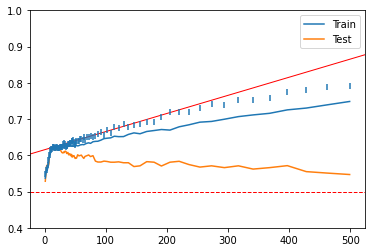

AT (10, 0.6205127282971595, 0.3075898173622724) WITH 91 ITERATIONS IN 158.3201946814855 SECONDS : 53.68039949377925
__main__.SVM_RFE_W_STEP - 00:02:58.586079100
poly 2 0.1


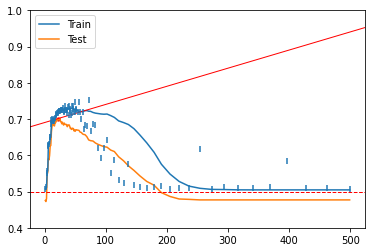

AT (21, 0.701003398608189, 0.24759728111344875) WITH 91 ITERATIONS IN 181.92700811227164 SECONDS : 36.358864099131445
__main__.SVM_RFE_W_STEP - 00:03:19.422350900
poly 2 0.2


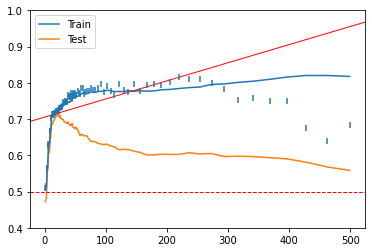

AT (20, 0.7155029280777784, 0.2355976575377773) WITH 91 ITERATIONS IN 173.3311690489451 SECONDS : 37.05469975317232
__main__.SVM_RFE_W_STEP - 00:03:11.155116900
poly 2 0.3


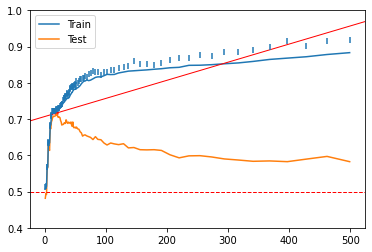

AT (19, 0.7164979350608093, 0.2344016519513526) WITH 91 ITERATIONS IN 176.56453136603037 SECONDS : 27.481094814865752
__main__.SVM_RFE_W_STEP - 00:03:14.150865500
poly 2 0.4


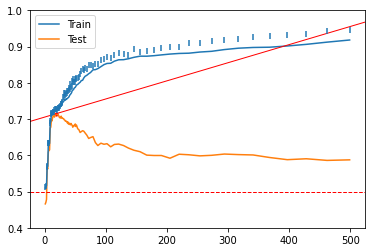

AT (19, 0.7150069230907553, 0.23559446152739577) WITH 91 ITERATIONS IN 172.5430695215861 SECONDS : 75.63885927230942
__main__.SVM_RFE_W_STEP - 00:03:18.098776500
poly 2 0.5


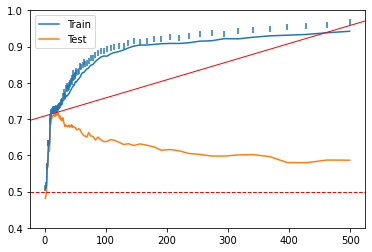

AT (19, 0.7179994365623109, 0.23320045075015128) WITH 91 ITERATIONS IN 171.28368417421976 SECONDS : 26.848678417703464
__main__.SVM_RFE_W_STEP - 00:03:08.776757900
poly 2 0.6


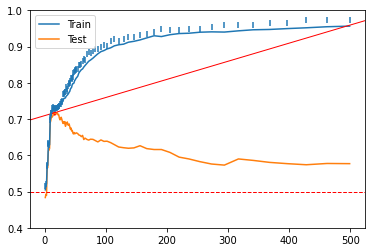

AT (15, 0.7170284056511601, 0.23237727547907194) WITH 91 ITERATIONS IN 165.53348875045776 SECONDS : 33.55862692562223
__main__.SVM_RFE_W_STEP - 00:03:03.525409900
poly 2 0.7


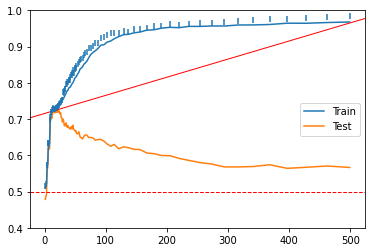

AT (19, 0.7250199301097505, 0.2275840559121996) WITH 91 ITERATIONS IN 164.6198362906774 SECONDS : 41.568807925523934
__main__.SVM_RFE_W_STEP - 00:03:05.346385100
poly 2 0.8


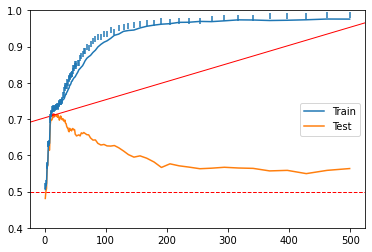

AT (14, 0.7104919290548034, 0.23720645675615729) WITH 91 ITERATIONS IN 161.39067002137503 SECONDS : 39.53567463705245
__main__.SVM_RFE_W_STEP - 00:03:00.937349500
poly 2 0.9


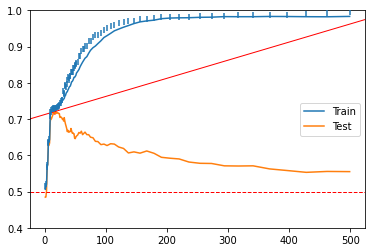

AT (16, 0.720512428596261, 0.22999005712299123) WITH 91 ITERATIONS IN 166.23833978176117 SECONDS : 53.286574205140795
__main__.SVM_RFE_W_STEP - 00:03:07.120694100
poly 3 0.1


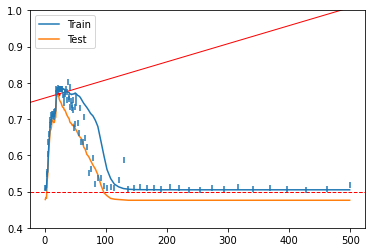

AT (21, 0.7684840529151907, 0.1936127576678474) WITH 91 ITERATIONS IN 182.9307837088903 SECONDS : 27.30786807545503
__main__.SVM_RFE_W_STEP - 00:03:28.651508000
poly 3 0.2


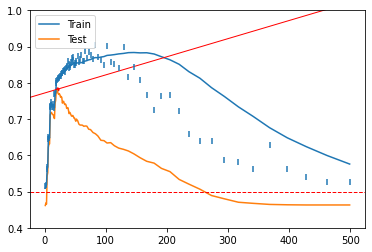

AT (20, 0.7819990649331965, 0.18240074805344283) WITH 91 ITERATIONS IN 180.17410218715668 SECONDS : 28.663521110559913
__main__.SVM_RFE_W_STEP - 00:03:26.405736700
poly 3 0.3


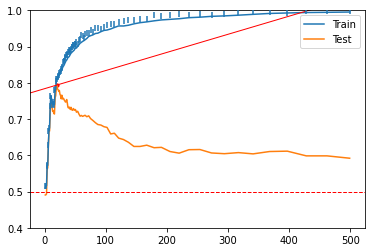

AT (20, 0.7939856023688359, 0.17281151810493134) WITH 91 ITERATIONS IN 176.60828642050424 SECONDS : 47.07045979461358
__main__.SVM_RFE_W_STEP - 00:03:24.186127600
poly 3 0.4


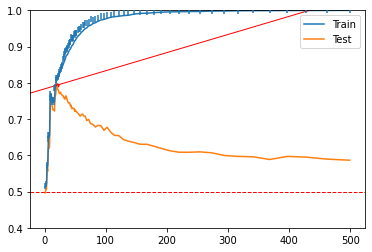

AT (20, 0.7934970899042755, 0.17320232807657965) WITH 91 ITERATIONS IN 181.16507144769034 SECONDS : 61.08905779250065
__main__.SVM_RFE_W_STEP - 00:03:30.474894000
poly 3 0.5


AT (20, 0.7874790958623294, 0.17801672331013646) WITH 91 ITERATIONS IN 175.96469020843506 SECONDS : 31.563443647087656
__main__.SVM_RFE_W_STEP - 00:03:24.009307900
poly 3 0.6


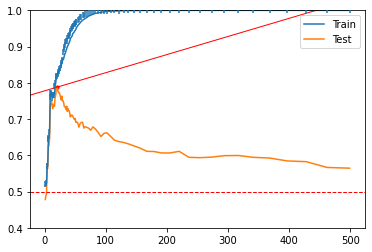

AT (20, 0.7879930829032625, 0.17760553367739) WITH 91 ITERATIONS IN 178.6708224217097 SECONDS : 35.97631360003729
__main__.SVM_RFE_W_STEP - 00:03:27.773935200
poly 3 0.7


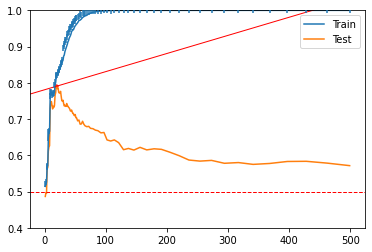

AT (19, 0.7904850958743174, 0.1752119233005461) WITH 91 ITERATIONS IN 175.61358511447906 SECONDS : 43.71108793437551
__main__.SVM_RFE_W_STEP - 00:03:26.265555100
poly 3 0.8


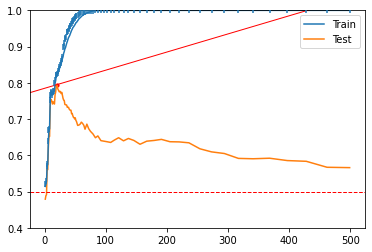

AT (20, 0.7950105794417172, 0.1719915364466263) WITH 91 ITERATIONS IN 173.8420955737432 SECONDS : 32.899924391128714
__main__.SVM_RFE_W_STEP - 00:03:23.775259300
poly 3 0.9


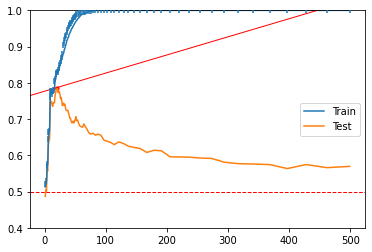

AT (20, 0.786978595361829, 0.1784171237105368) WITH 91 ITERATIONS IN 170.262188911438 SECONDS : 31.17769717665554
__main__.SVM_RFE_W_STEP - 00:03:19.598769900
poly 4 0.1


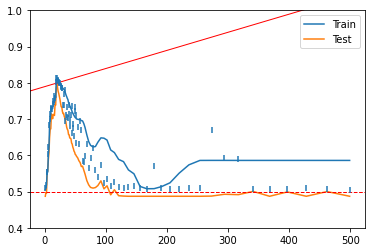

AT (20, 0.7995135854417291, 0.16838913164661673) WITH 91 ITERATIONS IN 189.3004901011785 SECONDS : 39.553216648579514
__main__.SVM_RFE_W_STEP - 00:03:37.571665100
poly 4 0.2


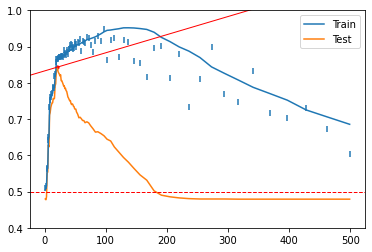

AT (20, 0.8429866992741243, 0.13361064058070057) WITH 91 ITERATIONS IN 185.50934255123138 SECONDS : 34.81230016705184
__main__.SVM_RFE_W_STEP - 00:03:33.160660700
poly 4 0.3


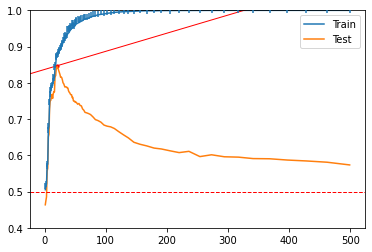

AT (20, 0.846995198791606, 0.1304038409667152) WITH 91 ITERATIONS IN 183.2974548737208 SECONDS : 26.38461044348119
__main__.SVM_RFE_W_STEP - 00:03:30.041054000
poly 4 0.4


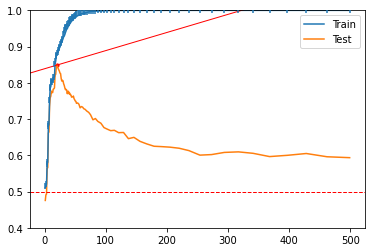

AT (20, 0.8489867112621604, 0.12881063099027168) WITH 91 ITERATIONS IN 181.9643838008245 SECONDS : 44.77451584568155
__main__.SVM_RFE_W_STEP - 00:03:31.476655700
poly 4 0.5


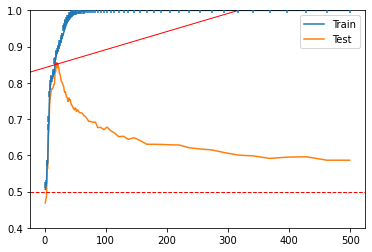

AT (19, 0.8510246773719828, 0.12678025810241372) WITH 91 ITERATIONS IN 184.63467903931937 SECONDS : 33.41320217683982
__main__.SVM_RFE_W_STEP - 00:03:34.069612800
poly 4 0.6


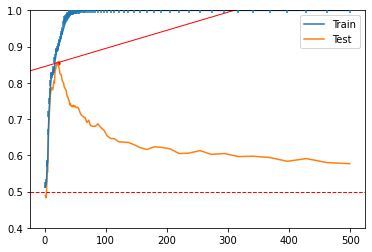

AT (21, 0.8555246863630096, 0.12398025090959233) WITH 91 ITERATIONS IN 180.2610512971878 SECONDS : 34.991042250019525
__main__.SVM_RFE_W_STEP - 00:03:29.036719400
poly 4 0.7


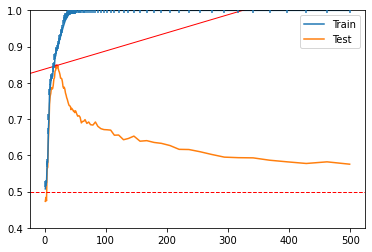

AT (19, 0.8474777172381963, 0.12961782620944295) WITH 91 ITERATIONS IN 175.9414537747701 SECONDS : 26.035536620246805
__main__.SVM_RFE_W_STEP - 00:03:23.836184700
poly 4 0.8


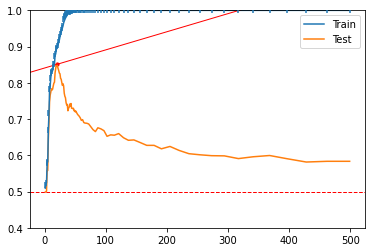

AT (20, 0.8509962057866249, 0.12720303537070005) WITH 91 ITERATIONS IN 176.19368811448416 SECONDS : 26.526045377923186
__main__.SVM_RFE_W_STEP - 00:03:23.793071000
poly 4 0.9


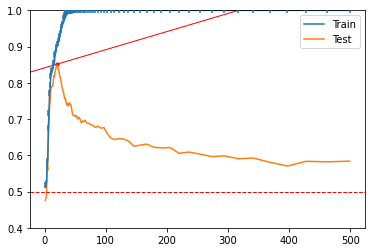

AT (20, 0.8514877152601704, 0.12680982779186367) WITH 91 ITERATIONS IN 180.73878892262778 SECONDS : 40.62033496366755
__main__.SVM_RFE_W_STEP - 00:03:29.634436000
poly 5 0.1


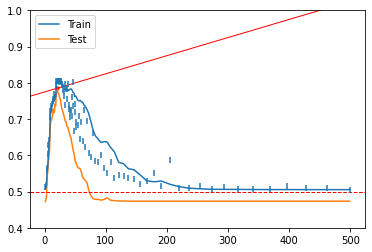

AT (20, 0.784976593359827, 0.18001872531213847) WITH 91 ITERATIONS IN 186.88558999697366 SECONDS : 26.083579585164646
__main__.SVM_RFE_W_STEP - 00:03:33.729527000
poly 5 0.2


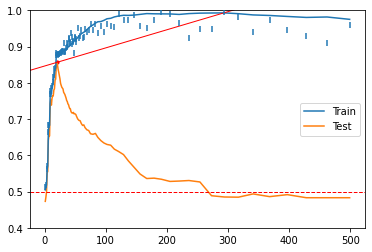

AT (20, 0.8564867262472053, 0.12281061900223572) WITH 91 ITERATIONS IN 185.4127178589503 SECONDS : 21.377279904648987
__main__.SVM_RFE_W_STEP - 00:03:31.317006800
poly 5 0.3


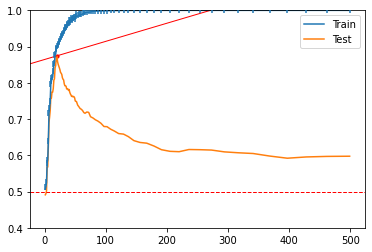

AT (20, 0.8744957532382683, 0.10840339740938534) WITH 91 ITERATIONS IN 185.69918115933737 SECONDS : 29.667242337567348
__main__.SVM_RFE_W_STEP - 00:03:35.119502900
poly 5 0.4


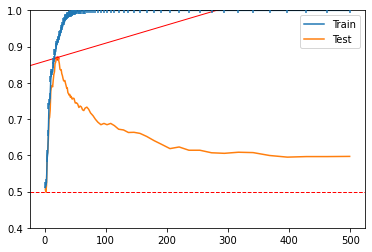

AT (20, 0.8695177213141285, 0.1123858229486972) WITH 91 ITERATIONS IN 181.42251106103262 SECONDS : 31.80540952476463
__main__.SVM_RFE_W_STEP - 00:03:28.823771200
poly 5 0.5


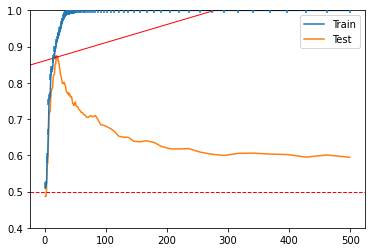

AT (19, 0.8705082327836818, 0.11119341377305453) WITH 91 ITERATIONS IN 183.9693303902944 SECONDS : 33.9776515577774
__main__.SVM_RFE_W_STEP - 00:03:33.872538400
poly 5 0.6


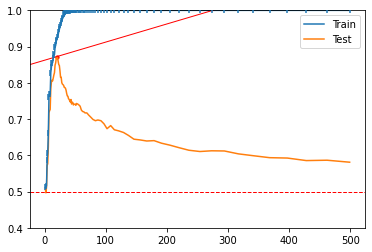

AT (20, 0.8725012437587288, 0.10999900499301693) WITH 91 ITERATIONS IN 184.91509211063385 SECONDS : 38.86826600376349
__main__.SVM_RFE_W_STEP - 00:03:34.976535400
poly 5 0.7


AT (20, 0.8695012377647108, 0.11239900978823139) WITH 91 ITERATIONS IN 180.29654550552368 SECONDS : 31.344309866604704
__main__.SVM_RFE_W_STEP - 00:03:29.528052100
poly 5 0.8


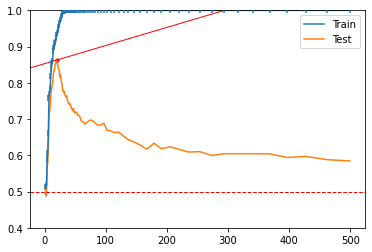

AT (20, 0.8630037222851593, 0.11759702217187257) WITH 91 ITERATIONS IN 177.83684424559274 SECONDS : 26.919247285873183
__main__.SVM_RFE_W_STEP - 00:03:26.408481700
poly 5 0.9


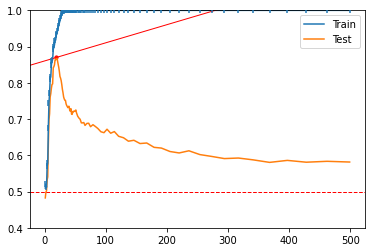

AT (19, 0.8699987412562263, 0.11160100699501893) WITH 91 ITERATIONS IN 181.47289669513702 SECONDS : 21.585445624952147
__main__.SVM_RFE_W_STEP - 00:03:29.363202200
poly 6 0.1


AT (20, 0.7770210330090569, 0.1863831735927545) WITH 91 ITERATIONS IN 192.17836662133536 SECONDS : 27.733696776518673
__main__.SVM_RFE_W_STEP - 00:03:39.034723000
poly 6 0.2


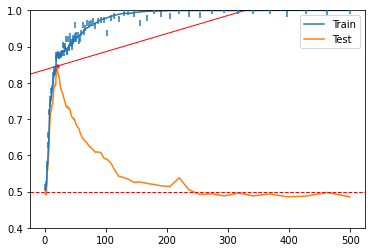

AT (20, 0.8460241678804553, 0.13118066569563575) WITH 91 ITERATIONS IN 188.37470869223276 SECONDS : 38.555133652812195
__main__.SVM_RFE_W_STEP - 00:03:36.728348700
poly 6 0.3


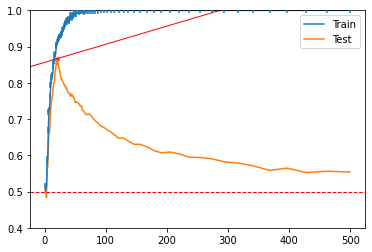

AT (20, 0.8665057272841704, 0.11479541817266367) WITH 91 ITERATIONS IN 187.66027172406515 SECONDS : 46.26474958841461
__main__.SVM_RFE_W_STEP - 00:03:36.945090400
poly 6 0.4


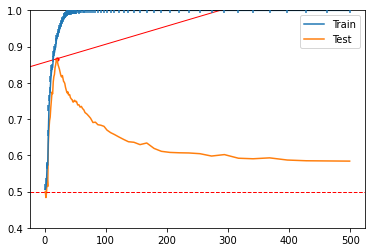

AT (20, 0.8665132198066331, 0.11478942415469354) WITH 91 ITERATIONS IN 186.57754651705423 SECONDS : 20.15168701702481
__main__.SVM_RFE_W_STEP - 00:03:33.473648900
poly 6 0.5


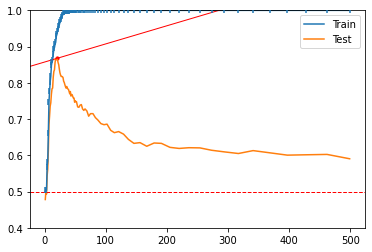

AT (20, 0.8674812537087986, 0.11401499703296114) WITH 91 ITERATIONS IN 184.52060596148172 SECONDS : 24.19410176979628
__main__.SVM_RFE_W_STEP - 00:03:32.022741900
poly 6 0.6


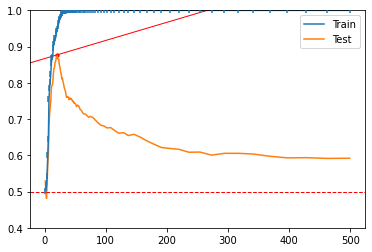

AT (20, 0.8770087452722185, 0.10639300378222522) WITH 91 ITERATIONS IN 185.30398110548654 SECONDS : 37.6723312515634
__main__.SVM_RFE_W_STEP - 00:03:33.917060500
poly 6 0.7


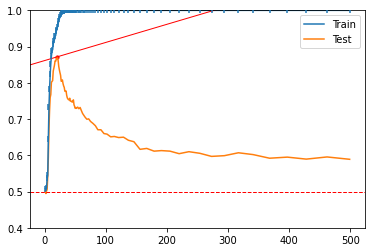

AT (20, 0.8715182248116379, 0.1107854201506897) WITH 91 ITERATIONS IN 184.6994836727778 SECONDS : 40.90165155007369
__main__.SVM_RFE_W_STEP - 00:03:34.257792000
poly 6 0.8


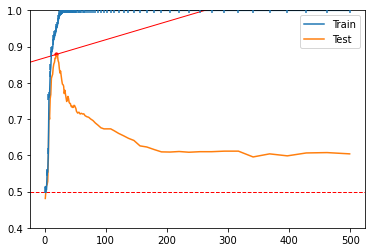

AT (19, 0.8784847721973469, 0.10481218224212249) WITH 91 ITERATIONS IN 183.05331254005432 SECONDS : 22.806587113227597
__main__.SVM_RFE_W_STEP - 00:03:30.549638400
poly 6 0.9


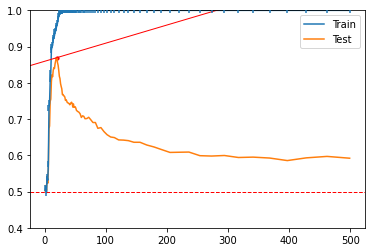

AT (20, 0.8695087302871732, 0.11239301577026142) WITH 91 ITERATIONS IN 181.22583178679147 SECONDS : 60.88469547795432
__main__.SVM_RFE_W_STEP - 00:03:33.285192200
poly 7 0.1


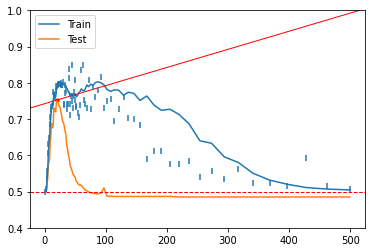

AT (20, 0.7524950099800399, 0.20600399201596808) WITH 91 ITERATIONS IN 189.8309544324875 SECONDS : 49.036406228727714
__main__.SVM_RFE_W_STEP - 00:03:39.029544700
poly 7 0.2


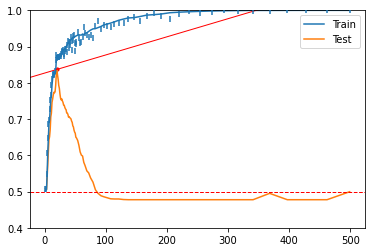

AT (20, 0.8369986753220285, 0.13840105974237718) WITH 91 ITERATIONS IN 183.4258315960566 SECONDS : 23.865001660394572
__main__.SVM_RFE_W_STEP - 00:03:30.845199200
poly 7 0.3


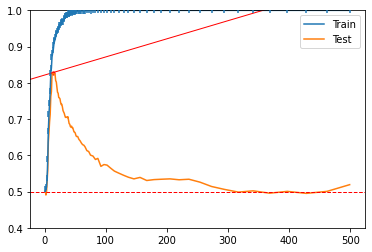

AT (13, 0.8280256304208399, 0.14277949566332812) WITH 91 ITERATIONS IN 186.8193179766337 SECONDS : 30.865776684959027
__main__.SVM_RFE_W_STEP - 00:03:35.169572400
poly 7 0.4


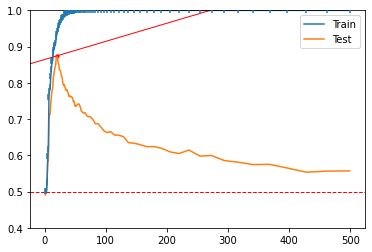

AT (20, 0.8744882607158057, 0.10840939142735548) WITH 91 ITERATIONS IN 185.55683596928915 SECONDS : 100.2158570669905
__main__.SVM_RFE_W_STEP - 00:03:41.109405800
poly 7 0.5


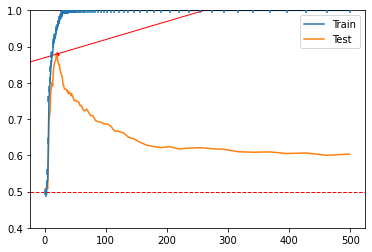

AT (20, 0.8794977612342881, 0.1044017910125695) WITH 91 ITERATIONS IN 183.78572793801627 SECONDS : 40.21491819379629
__main__.SVM_RFE_W_STEP - 00:03:33.414426300
poly 7 0.6


AT (19, 0.8765112417807028, 0.10639100657543774) WITH 91 ITERATIONS IN 184.34801995754242 SECONDS : 27.608091720643557
__main__.SVM_RFE_W_STEP - 00:03:32.242219100
poly 7 0.7


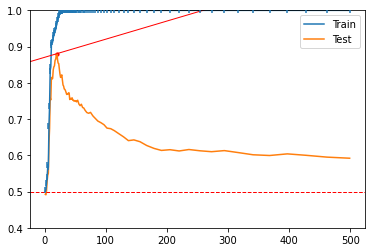

AT (20, 0.8804942667218117, 0.10360458662255062) WITH 91 ITERATIONS IN 182.5605902671814 SECONDS : 43.80511914179177
__main__.SVM_RFE_W_STEP - 00:03:33.014160400
poly 7 0.8


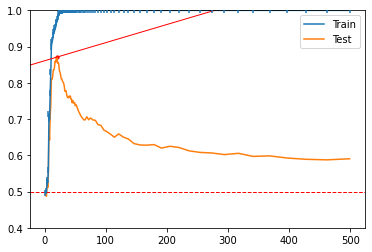

AT (20, 0.8709832587078097, 0.11121339303375227) WITH 91 ITERATIONS IN 179.0270623366038 SECONDS : 34.58712383478355
__main__.SVM_RFE_W_STEP - 00:03:28.541467500
poly 7 0.9


AT (20, 0.8669972367577158, 0.11440221059382738) WITH 91 ITERATIONS IN 180.21553492546082 SECONDS : 23.574444772410875
__main__.SVM_RFE_W_STEP - 00:03:27.866415300
poly 8 0.1


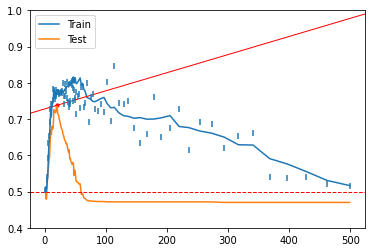

AT (20, 0.7379759999520479, 0.21761920003836172) WITH 91 ITERATIONS IN 195.29091676076254 SECONDS : 47.383109173844055
__main__.SVM_RFE_W_STEP - 00:03:47.928567400
poly 8 0.2


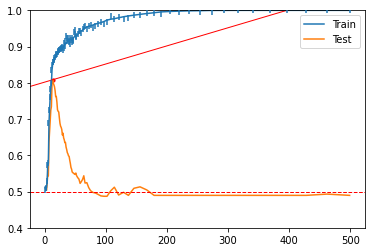

AT (13, 0.8084836333339327, 0.15841309333285386) WITH 91 ITERATIONS IN 195.61149982611337 SECONDS : 20.731456222001054
__main__.SVM_RFE_W_STEP - 00:03:43.798064900
poly 8 0.3


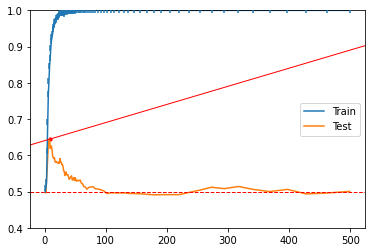

AT (8, 0.6444843046639454, 0.2876125562688437) WITH 91 ITERATIONS IN 198.12216703097025 SECONDS : 24.36774490195131
__main__.SVM_RFE_W_STEP - 00:03:45.987436000
poly 8 0.4


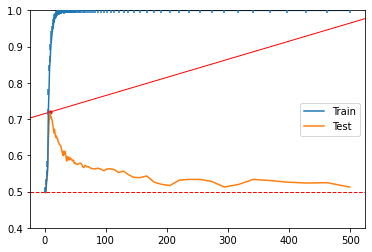

AT (8, 0.7190393986801172, 0.22796848105590622) WITH 91 ITERATIONS IN 198.27373532454172 SECONDS : 63.525029828662895
__main__.SVM_RFE_W_STEP - 00:03:50.598254200
poly 8 0.5


AT (19, 0.8720037402672135, 0.1099970077862292) WITH 91 ITERATIONS IN 190.50181126594543 SECONDS : 49.498256084960836
__main__.SVM_RFE_W_STEP - 00:03:41.954571700
poly 8 0.6


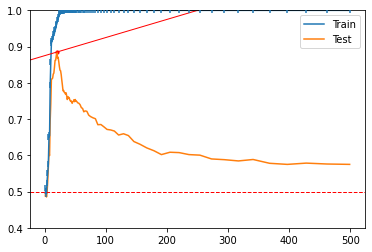

AT (20, 0.8849927772083461, 0.1000057782333231) WITH 91 ITERATIONS IN 185.99446165561676 SECONDS : 32.69425343617914
__main__.SVM_RFE_W_STEP - 00:03:35.339216500
poly 8 0.7


AT (20, 0.8765082447717178, 0.10679340418262573) WITH 91 ITERATIONS IN 188.09337838490805 SECONDS : 24.855466752966677
__main__.SVM_RFE_W_STEP - 00:03:36.315623500
poly 8 0.8


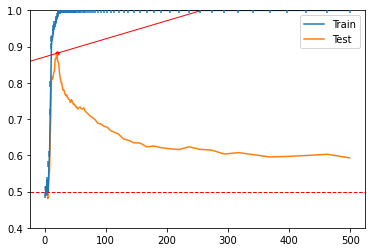

AT (20, 0.8814922707138276, 0.10280618342893791) WITH 91 ITERATIONS IN 189.80583782990774 SECONDS : 28.923280230512443
__main__.SVM_RFE_W_STEP - 00:03:37.596178400
poly 8 0.9


AT (19, 0.8664877452302601, 0.11440980381579195) WITH 91 ITERATIONS IN 187.23766016960144 SECONDS : 62.41923546613949
__main__.SVM_RFE_W_STEP - 00:03:39.228053700
poly 9 0.1


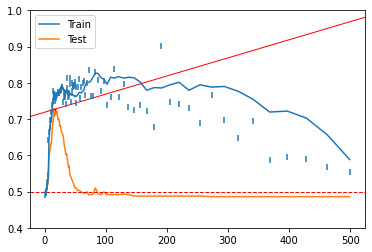

AT (15, 0.7264285243327159, 0.2248571805338273) WITH 91 ITERATIONS IN 197.13974114259085 SECONDS : 29.464158231659884
__main__.SVM_RFE_W_STEP - 00:03:45.221901600
poly 9 0.2


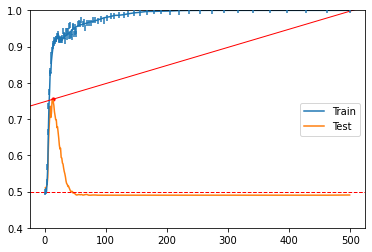

AT (13, 0.7544745344146541, 0.20162037246827677) WITH 91 ITERATIONS IN 198.27152140935263 SECONDS : 21.669465888707283
__main__.SVM_RFE_W_STEP - 00:03:46.133772300
poly 9 0.3


AT (7, 0.6593974213734694, 0.27528206290122453) WITH 91 ITERATIONS IN 205.47989253203073 SECONDS : 63.83521919690955
__main__.SVM_RFE_W_STEP - 00:03:57.735429700
poly 9 0.4


AT (7, 0.639530248811686, 0.29117580095065126) WITH 91 ITERATIONS IN 201.527592142423 SECONDS : 49.34411651949966
__main__.SVM_RFE_W_STEP - 00:03:56.340163600
poly 9 0.5


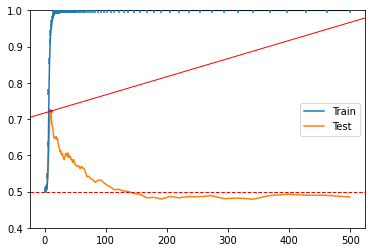

AT (9, 0.7214534894175614, 0.2264372084659509) WITH 91 ITERATIONS IN 205.8503074248632 SECONDS : 18.103050293848856
__main__.SVM_RFE_W_STEP - 00:03:55.607783300
poly 9 0.6


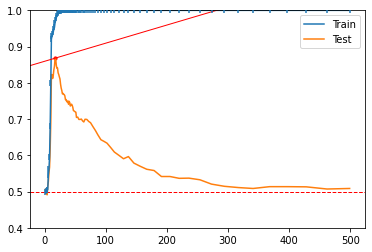

AT (17, 0.8680147213081343, 0.11238822295349257) WITH 91 ITERATIONS IN 190.5004000266393 SECONDS : 22.666444696518045
__main__.SVM_RFE_W_STEP - 00:03:38.993293200
poly 9 0.7


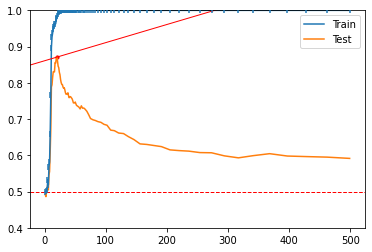

AT (20, 0.8710072347796899, 0.11119421217624809) WITH 91 ITERATIONS IN 191.0427853266398 SECONDS : 26.994256006775398
__main__.SVM_RFE_W_STEP - 00:03:39.752037200
poly 9 0.8


AT (19, 0.867009224793656, 0.11399262016507516) WITH 91 ITERATIONS IN 193.0437754789988 SECONDS : 28.740758847318656
__main__.SVM_RFE_W_STEP - 00:03:42.251141100
poly 9 0.9


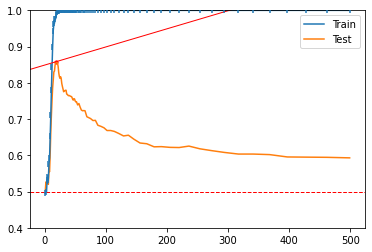

AT (19, 0.8585276893660128, 0.1207778485071898) WITH 91 ITERATIONS IN 192.16436592737833 SECONDS : 72.6724908022853
__main__.SVM_RFE_W_STEP - 00:03:44.726401000


In [14]:
model_selection = {}
for degree in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    for C in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        model_selection[C, degree] = SVM_RFE_W_STEP(20, C, degree, 'poly', sampling_p=0.6, dstep_p=0.08, dstop = 30)

In [20]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + str(C) + '}', '', '', '']

for C, d in model_selection:
    col = {7: 1, 8: 2, 9: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[0][2])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.1} &    20 & 75.25\% & 0.206 &    20 & 73.80\% & 0.218 &    15 & 72.64\% & 0.225\\
\textbf{0.2} &    20 & 83.70\% & 0.138 &    13 & 80.85\% & 0.158 &    13 & 75.45\% & 0.202\\
\textbf{0.3} &    13 & 82.80\% & 0.143 &     8 & 64.45\% & 0.288 &     7 & 65.94\% & 0.275\\
\textbf{0.4} &    20 & 87.45\% & 0.108 &     8 & 71.90\% & 0.228 &     7 & 63.95\% & 0.291\\
\textbf{0.5} &    20 & 87.95\% & 0.104 &    19 & 87.20\% & 0.110 &     9 & 72.15\% & 0.226\\
\textbf{0.6} &    19 & 87.65\% & 0.106 &    20 & 88.50\% & 0.100 &    17 & 86.80\% & 0.112\\
\textbf{0.7} &    20 & 88.05\% & 0.104 &    20 & 87.65\% & 0.107 &    20 & 87.10\% & 0.111\\
\textbf{0.8} &    20 & 87.10\% & 0.111 &    20 & 88.15\% & 0.103 &    19 & 86.70\% & 0.114\\
\textbf{0.9} &    20 & 86.70\% & 0.114 &    19 & 86.65\% & 0.114 &    19 & 85.85\% & 0.121\\


In [31]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + str(C) + '}', '', '', '', '', '', '', '', '', '']

for C, d in model_selection:
    col = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}".format(v[1]/60, str(int(v[1] % 60)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.1} & 3:58 & 3:01 & 3:02 & 3:09 & 3:06 & 3:12 & 3:09 & 3:15 & 3:17\\
\textbf{0.2} & 3:51 & 3:53 & 3:00 & 3:05 & 3:05 & 3:08 & 3:03 & 3:15 & 3:18\\
\textbf{0.3} & 3:49 & 3:56 & 3:56 & 3:03 & 3:05 & 3:07 & 3:06 & 3:18 & 3:25\\
\textbf{0.4} & 3:48 & 3:52 & 3:01 & 3:01 & 3:01 & 3:06 & 3:05 & 3:18 & 3:21\\
\textbf{0.5} & 3:48 & 3:51 & 3:55 & 3:04 & 3:03 & 3:04 & 3:03 & 3:10 & 3:25\\
\textbf{0.6} & 3:46 & 3:45 & 3:58 & 3:00 & 3:04 & 3:05 & 3:04 & 3:05 & 3:10\\
\textbf{0.7} & 3:43 & 3:44 & 3:55 & 3:55 & 3:00 & 3:04 & 3:02 & 3:08 & 3:11\\
\textbf{0.8} & 3:41 & 3:41 & 3:53 & 3:56 & 3:57 & 3:03 & 3:59 & 3:09 & 3:13\\
\textbf{0.9} & 3:38 & 3:46 & 3:50 & 3:00 & 3:01 & 3:01 & 3:00 & 3:07 & 3:12\\


In [38]:
C = 0.9
f = 500
i = 20
C*(i/f*0.9 + 0.1)

0.12240000000000001

poly 5 0.6


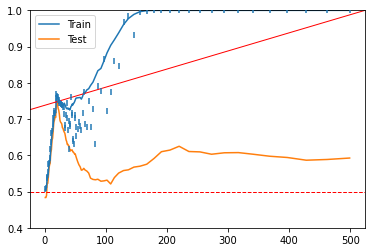

AT (20, 0.7480069890249531, 0.20959440878003754) WITH 91 ITERATIONS IN 200.66626664002737 SECONDS : 58.244980222050806
__main__.SVM_RFE_W_STEP - 00:03:51.048641500


((20, 0.7480069890249531, 0.20959440878003754), 200.66626664002737)

In [8]:
SVM_RFE_W_STEP(20, 0.6, 5, 'poly', sampling_p=0.6, dstep_p=0.08, dstop = 30)

poly 3 0.9


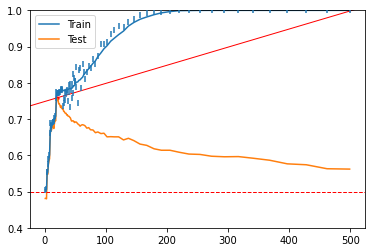

AT (20, 0.758475541409673, 0.2012195668722616) WITH 91 ITERATIONS IN 191.1409179766973 SECONDS : 123.39312277148701
__main__.SVM_RFE_W_STEP - 00:03:44.849691700


((20, 0.758475541409673, 0.2012195668722616), 191.1409179766973)

In [10]:
SVM_RFE_W_STEP(20, 0.9, 3, 'poly', sampling_p=0.6, dstep_p=0.08, dstop = 30)

rbf 3 0.9


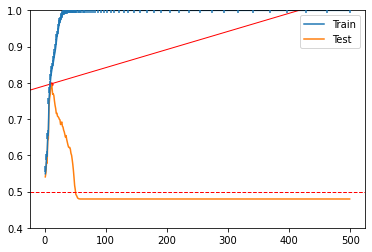

AT (11, 0.7974606342869817, 0.16643149257041467) WITH 91 ITERATIONS IN 223.7351474761963 SECONDS : 34.55088243660847
__main__.SVM_RFE_W_STEP - 00:04:07.919035800


((11, 0.7974606342869817, 0.16643149257041467), 223.7351474761963)

In [11]:
SVM_RFE_W_STEP(20, 0.9, gamma=0.1, kernel='rbf', sampling_p=0.6, dstep_p=0.08, dstop = 30)

rbf 3 0.1


AT (20, 0.6960253666840494, 0.2511797066527605) WITH 91 ITERATIONS IN 214.0794857343038 SECONDS : 43.54390348505752
__main__.SVM_RFE_W_STEP - 00:03:57.489597900
rbf 3 0.2


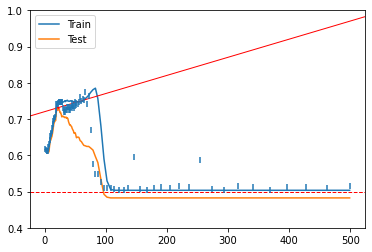

AT (20, 0.7305119490748234, 0.22359044074014128) WITH 91 ITERATIONS IN 230.7102126677831 SECONDS : 46.59488787691702
__main__.SVM_RFE_W_STEP - 00:04:15.524338700
rbf 3 0.3


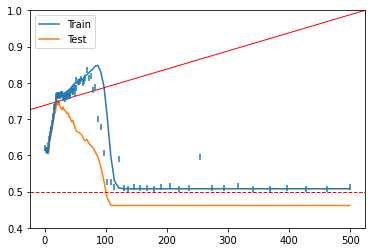

AT (20, 0.7480249710788632, 0.20958002313690943) WITH 91 ITERATIONS IN 228.0252376794815 SECONDS : 35.52450131126454
__main__.SVM_RFE_W_STEP - 00:04:12.065346000
rbf 3 0.4


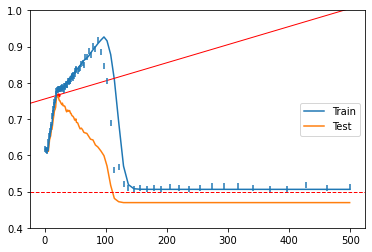

AT (21, 0.7659905414396433, 0.19560756684828537) WITH 91 ITERATIONS IN 230.57177778085074 SECONDS : 44.029448854486354
__main__.SVM_RFE_W_STEP - 00:04:15.718644800
rbf 3 0.5


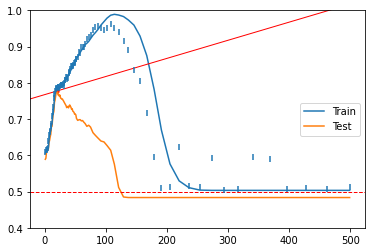

AT (20, 0.7774780768792744, 0.1860175384965805) WITH 91 ITERATIONS IN 230.10173539320627 SECONDS : 51.14305307725562
__main__.SVM_RFE_W_STEP - 00:04:17.058936400
rbf 3 0.6


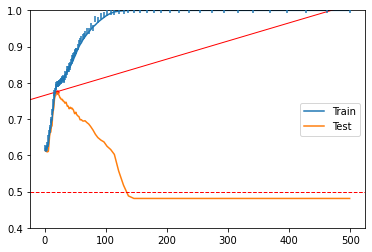

AT (20, 0.7754850659042276, 0.18761194727661792) WITH 91 ITERATIONS IN 226.2754317522049 SECONDS : 46.06690160260904
__main__.SVM_RFE_W_STEP - 00:04:10.406843100
rbf 3 0.7


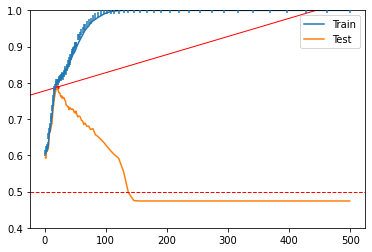

AT (20, 0.7879960799122476, 0.17760313607020192) WITH 91 ITERATIONS IN 233.1857138077418 SECONDS : 39.74951162853333
__main__.SVM_RFE_W_STEP - 00:04:17.633692200
rbf 3 0.8


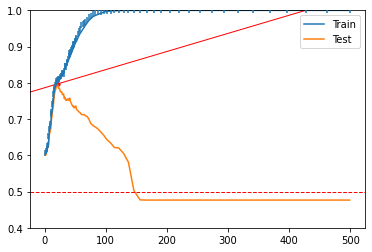

AT (21, 0.7970185754616893, 0.17078513963064856) WITH 91 ITERATIONS IN 226.4061983426412 SECONDS : 46.11402923206186
__main__.SVM_RFE_W_STEP - 00:04:10.483640700
rbf 3 0.9


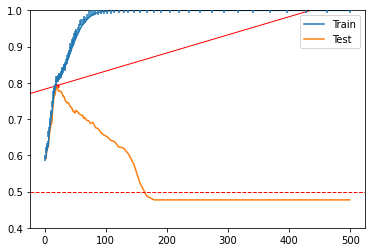

AT (20, 0.792497587407767, 0.17400193007378642) WITH 91 ITERATIONS IN 223.4281723499298 SECONDS : 32.864584147799896
__main__.SVM_RFE_W_STEP - 00:04:08.702165200
rbf 3 0.1


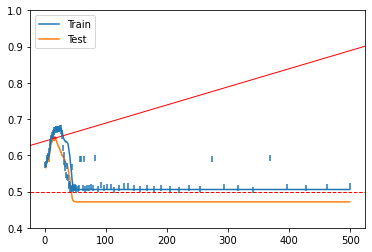

AT (16, 0.6469718221215227, 0.28882254230278187) WITH 91 ITERATIONS IN 237.76592095692953 SECONDS : 58.97995406614961
__main__.SVM_RFE_W_STEP - 00:04:23.586205200
rbf 3 0.2


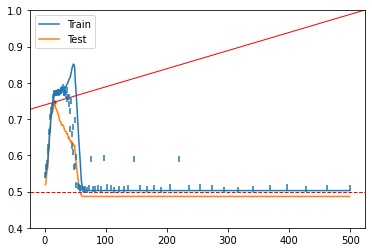

AT (15, 0.7465084845324367, 0.20879321237405069) WITH 91 ITERATIONS IN 237.44284963607788 SECONDS : 37.87834754785653
__main__.SVM_RFE_W_STEP - 00:04:21.441246200
rbf 3 0.3


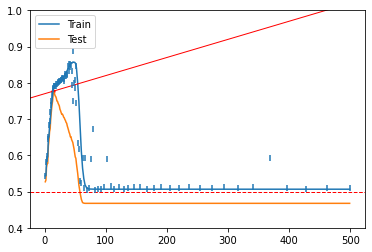

AT (14, 0.7769985554416691, 0.18400115564666475) WITH 91 ITERATIONS IN 238.91487320264181 SECONDS : 65.39115387613305
__main__.SVM_RFE_W_STEP - 00:04:25.673268100
rbf 3 0.4


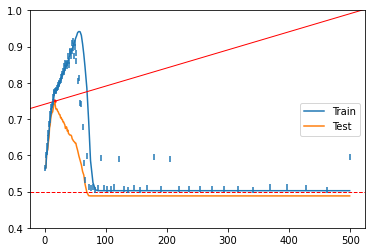

AT (16, 0.7490364616113118, 0.20717083071095058) WITH 91 ITERATIONS IN 210.19554221630096 SECONDS : 35.761385534112485
__main__.SVM_RFE_W_STEP - 00:03:53.076227100
rbf 3 0.5


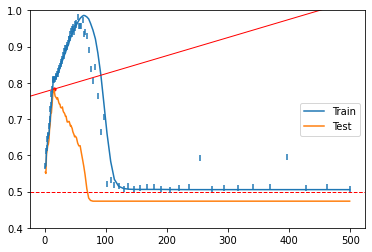

AT (15, 0.7825475175774576, 0.17996198593803397) WITH 91 ITERATIONS IN 210.836900472641 SECONDS : 46.69046439495283
__main__.SVM_RFE_W_STEP - 00:03:56.186389500
rbf 3 0.6


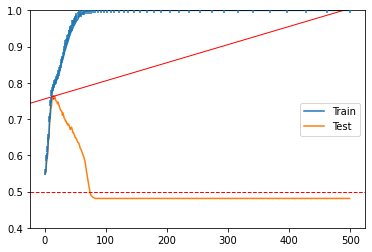

AT (13, 0.7620524716333099, 0.1955580226933521) WITH 91 ITERATIONS IN 227.71725257237753 SECONDS : 72.08150211941727
__main__.SVM_RFE_W_STEP - 00:04:14.344157300
rbf 3 0.7


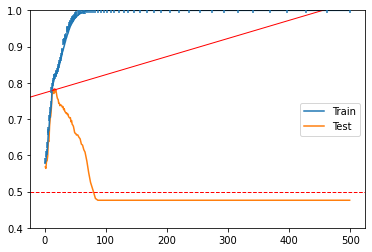

AT (16, 0.7804780828732923, 0.1820175337013661) WITH 91 ITERATIONS IN 233.3580834468206 SECONDS : 37.2254070035329
__main__.SVM_RFE_W_STEP - 00:04:19.559273200
rbf 3 0.8


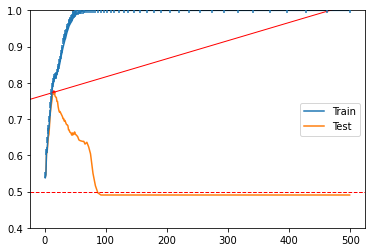

AT (14, 0.7734950519381657, 0.18680395844946746) WITH 91 ITERATIONS IN 226.23400155703226 SECONDS : 37.07978967549678
__main__.SVM_RFE_W_STEP - 00:04:10.663380900
rbf 3 0.9


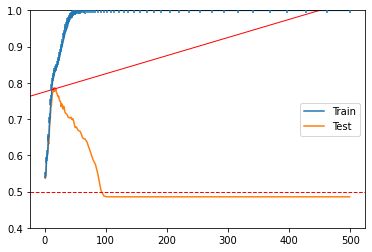

AT (16, 0.7831034627441813, 0.17991722980465497) WITH 91 ITERATIONS IN 223.08575479189554 SECONDS : 58.718150957514574
__main__.SVM_RFE_W_STEP - 00:04:10.186563700
rbf 3 0.1


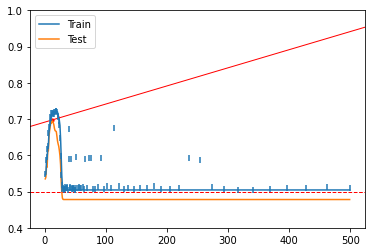

AT (12, 0.6974789160417902, 0.2468168671665678) WITH 91 ITERATIONS IN 236.53804314136505 SECONDS : 33.0550450531775
__main__.SVM_RFE_W_STEP - 00:04:20.658677700
rbf 3 0.2


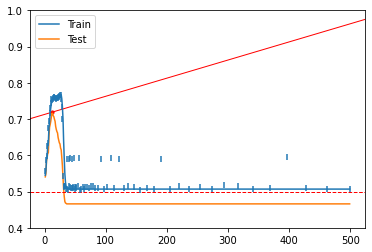

AT (12, 0.718971965977954, 0.22962242721763682) WITH 91 ITERATIONS IN 225.7533138593038 SECONDS : 25.75877075062292
__main__.SVM_RFE_W_STEP - 00:04:09.231990400
rbf 3 0.3


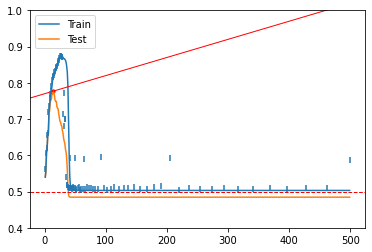

AT (14, 0.7770090449731168, 0.18399276402150652) WITH 91 ITERATIONS IN 223.05277891953787 SECONDS : 56.516947689653044
__main__.SVM_RFE_W_STEP - 00:04:08.725935100
rbf 3 0.4


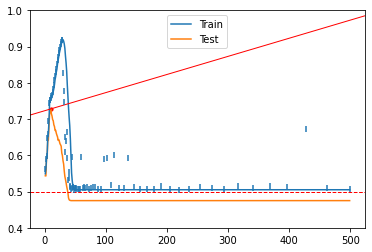

AT (10, 0.7280499061936188, 0.221560075045105) WITH 91 ITERATIONS IN 229.13522175947824 SECONDS : 34.6567687522441
__main__.SVM_RFE_W_STEP - 00:04:13.050476700
rbf 3 0.5


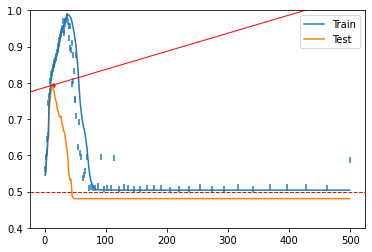

AT (13, 0.7935180689671707, 0.17038554482626347) WITH 91 ITERATIONS IN 222.95481626192728 SECONDS : 65.07160469250123
__main__.SVM_RFE_W_STEP - 00:04:08.740552200
rbf 3 0.6


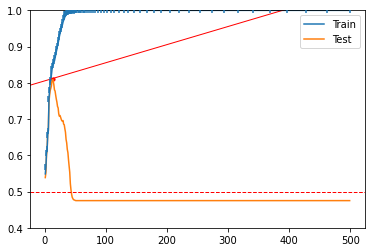

AT (13, 0.8119421817026607, 0.15564625463787143) WITH 91 ITERATIONS IN 227.56148918469748 SECONDS : 21.8625212589268
__main__.SVM_RFE_W_STEP - 00:04:11.550990900
rbf 3 0.7


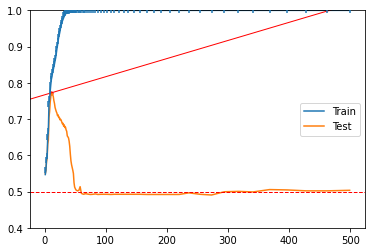

AT (11, 0.7724760688832545, 0.18641914489339642) WITH 91 ITERATIONS IN 226.03693731625876 SECONDS : 18.812553203183022
__main__.SVM_RFE_W_STEP - 00:04:08.854260500
rbf 3 0.8


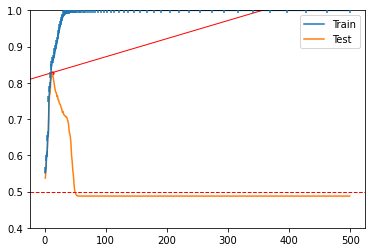

AT (12, 0.827976179772587, 0.14241905618193043) WITH 91 ITERATIONS IN 231.40692031383514 SECONDS : 53.45360505918933
__main__.SVM_RFE_W_STEP - 00:04:16.887784500
rbf 3 0.9


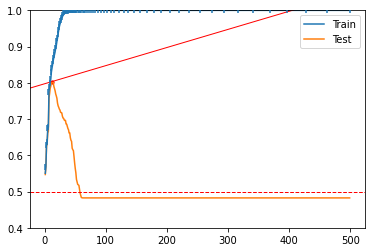

AT (12, 0.8035070999142855, 0.16199432006857162) WITH 91 ITERATIONS IN 236.76068437099457 SECONDS : 40.57683358258683
__main__.SVM_RFE_W_STEP - 00:04:21.388969900
rbf 3 0.1


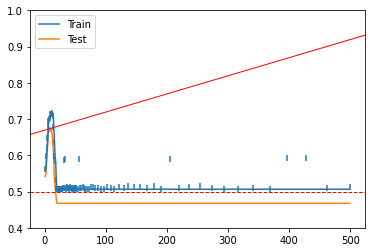

AT (7, 0.6730083376789963, 0.264393329856803) WITH 91 ITERATIONS IN 230.96534876028696 SECONDS : 43.749254624699034
__main__.SVM_RFE_W_STEP - 00:04:16.530254500
rbf 3 0.2


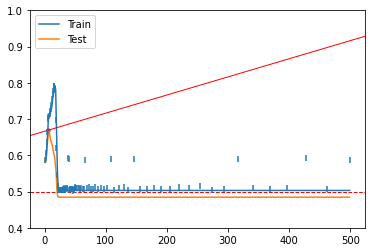

AT (6, 0.6694388999778221, 0.2668488800177423) WITH 91 ITERATIONS IN 228.25775158405304 SECONDS : 52.2129560013528
__main__.SVM_RFE_W_STEP - 00:04:13.333946700
rbf 3 0.3


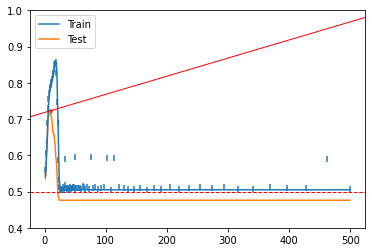

AT (9, 0.7228860597124069, 0.22529115223007445) WITH 91 ITERATIONS IN 229.11790625254312 SECONDS : 9.885258093337704
__main__.SVM_RFE_W_STEP - 00:04:11.132796800
rbf 3 0.4


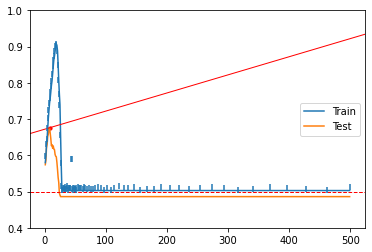

AT (8, 0.6760368152583721, 0.2623705477933023) WITH 91 ITERATIONS IN 226.5825854142507 SECONDS : 38.024743166976535
__main__.SVM_RFE_W_STEP - 00:04:10.941111200
rbf 3 0.5


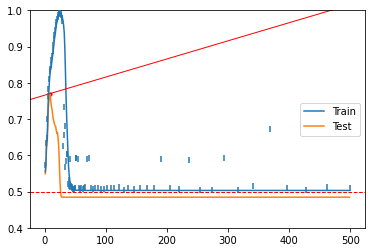

AT (9, 0.7704455952958947, 0.1872435237632842) WITH 91 ITERATIONS IN 220.85004576047263 SECONDS : 22.64867888588495
__main__.SVM_RFE_W_STEP - 00:04:04.316268100
rbf 3 0.6


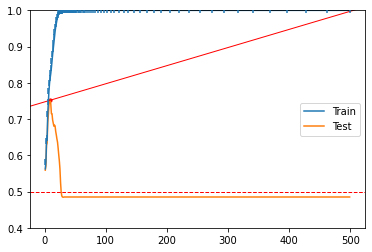

AT (9, 0.7519690349031668, 0.20202477207746655) WITH 91 ITERATIONS IN 218.59733700752258 SECONDS : 25.98705852889979
__main__.SVM_RFE_W_STEP - 00:04:01.669508100
rbf 3 0.7


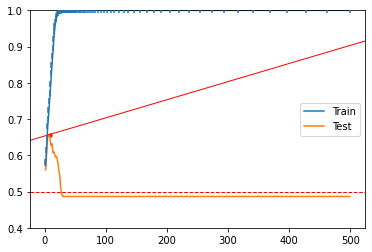

AT (8, 0.6574044103984223, 0.2772764716812621) WITH 91 ITERATIONS IN 215.247300585111 SECONDS : 25.82957420874257
__main__.SVM_RFE_W_STEP - 00:03:57.082468500
rbf 3 0.8


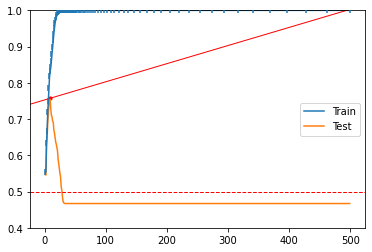

AT (8, 0.756957556358754, 0.19763395491299687) WITH 91 ITERATIONS IN 213.2652207215627 SECONDS : 24.417947948327395
__main__.SVM_RFE_W_STEP - 00:03:55.184745900
rbf 3 0.9


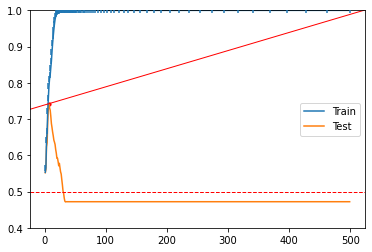

AT (7, 0.7425464386542231, 0.20876284907662154) WITH 91 ITERATIONS IN 214.705748518308 SECONDS : 19.90909794424608
__main__.SVM_RFE_W_STEP - 00:03:57.784014600
rbf 3 0.1


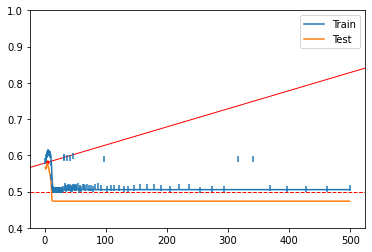

AT (4, 0.5804891718065371, 0.3372086625547703) WITH 91 ITERATIONS IN 216.5231189330419 SECONDS : 20.250978254036198
__main__.SVM_RFE_W_STEP - 00:03:57.937105500
rbf 3 0.2


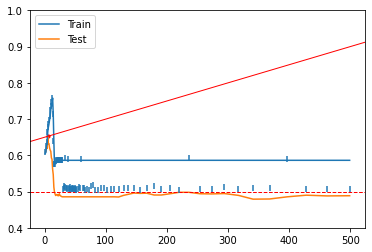

AT (5, 0.6524848201494908, 0.28001214388040735) WITH 91 ITERATIONS IN 214.78339087963104 SECONDS : 20.480605774809927
__main__.SVM_RFE_W_STEP - 00:03:56.224110200
rbf 3 0.3


AT (3, 0.6009902117686549, 0.3204078305850761) WITH 91 ITERATIONS IN 224.9428938627243 SECONDS : 35.86349570129366
__main__.SVM_RFE_W_STEP - 00:04:09.923987000
rbf 3 0.4


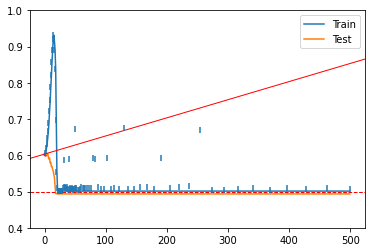

AT (1, 0.6040291788794784, 0.31717665689641733) WITH 91 ITERATIONS IN 226.90641991297403 SECONDS : 76.37523910151359
__main__.SVM_RFE_W_STEP - 00:04:13.933829200
rbf 3 0.5


AT (3, 0.5425245604886323, 0.3671803516090942) WITH 91 ITERATIONS IN 221.37653168042502 SECONDS : 15.045724579916277
__main__.SVM_RFE_W_STEP - 00:04:06.390825000
rbf 3 0.6


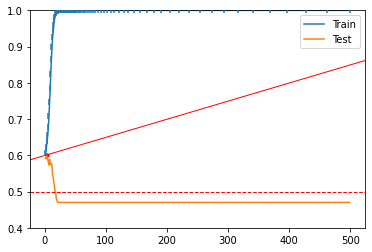

AT (3, 0.6009797222372073, 0.32041622221023414) WITH 91 ITERATIONS IN 232.56034290790558 SECONDS : 45.440109492739026
__main__.SVM_RFE_W_STEP - 00:04:19.841988300
rbf 3 0.7


AT (4, 0.6305002607397817, 0.29719979140817465) WITH 91 ITERATIONS IN 228.67598617076874 SECONDS : 49.56248169996735
__main__.SVM_RFE_W_STEP - 00:04:14.330288700
rbf 3 0.8


AT (3, 0.6419683156210102, 0.28762534750319185) WITH 91 ITERATIONS IN 231.49407986799875 SECONDS : 29.65142669589315
__main__.SVM_RFE_W_STEP - 00:04:17.832523600
rbf 3 0.9


AT (5, 0.6275497053940168, 0.2999602356847866) WITH 91 ITERATIONS IN 239.72044638792673 SECONDS : 29.684344754941822
__main__.SVM_RFE_W_STEP - 00:04:28.169952400
rbf 3 0.1


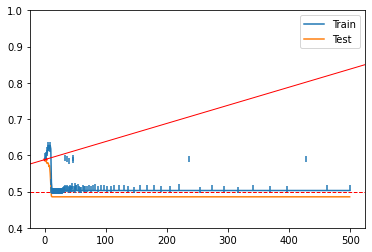

AT (1, 0.5885721050391709, 0.3295423159686633) WITH 91 ITERATIONS IN 240.88414673010507 SECONDS : 50.21074595885835
__main__.SVM_RFE_W_STEP - 00:04:26.694515900
rbf 3 0.2


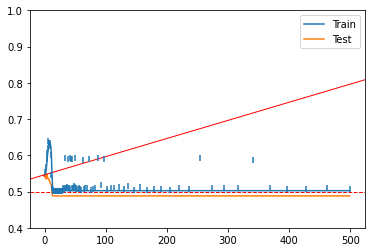

AT (1, 0.5469856083628539, 0.3628115133097169) WITH 91 ITERATIONS IN 233.05446966489157 SECONDS : 22.24103021043504
__main__.SVM_RFE_W_STEP - 00:04:16.000821000
rbf 3 0.3


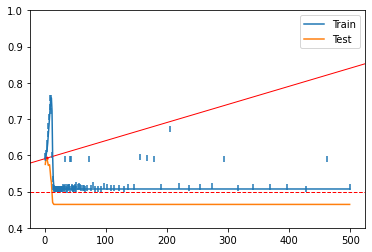

AT (2, 0.5915211618804433, 0.3275830704956454) WITH 91 ITERATIONS IN 228.25436186790466 SECONDS : 31.731041922438806
__main__.SVM_RFE_W_STEP - 00:04:13.443311700
rbf 3 0.4


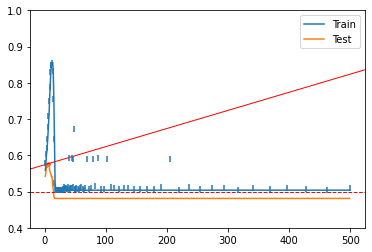

AT (6, 0.5770261279243315, 0.3407790976605348) WITH 91 ITERATIONS IN 228.8718068997065 SECONDS : 38.885308454469154
__main__.SVM_RFE_W_STEP - 00:04:13.156065300
rbf 3 0.5


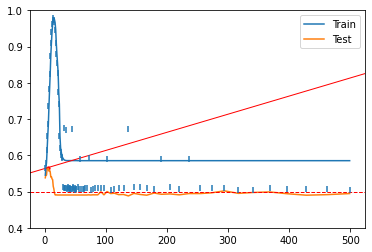

AT (5, 0.5659821498144851, 0.34921428014841194) WITH 91 ITERATIONS IN 230.05707168579102 SECONDS : 34.95407991876616
__main__.SVM_RFE_W_STEP - 00:04:14.092180400
rbf 3 0.6


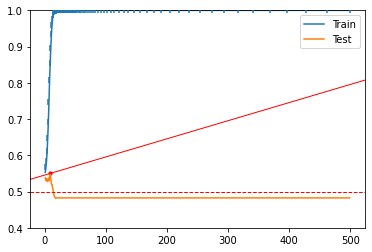

AT (9, 0.5500305694916473, 0.36357554440668216) WITH 91 ITERATIONS IN 238.71378127733865 SECONDS : 57.46579143792281
__main__.SVM_RFE_W_STEP - 00:04:27.752067500
rbf 3 0.7


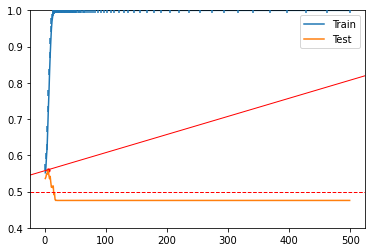

AT (5, 0.559964155772539, 0.3540286753819688) WITH 91 ITERATIONS IN 233.6016083161036 SECONDS : 30.705268647710174
__main__.SVM_RFE_W_STEP - 00:04:20.053532200
rbf 3 0.8


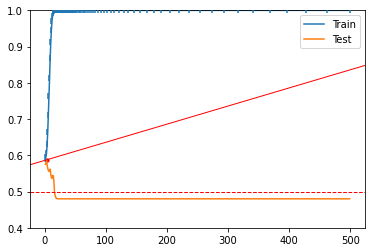

AT (3, 0.5874991758225291, 0.33120065934197673) WITH 91 ITERATIONS IN 230.15655533472696 SECONDS : 26.5294687632536
__main__.SVM_RFE_W_STEP - 00:04:14.237300200
rbf 3 0.9


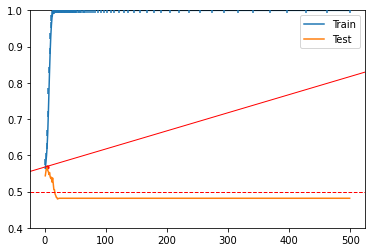

AT (3, 0.5690346034657412, 0.34597231722740707) WITH 91 ITERATIONS IN 232.09135230382284 SECONDS : 35.058069544776
__main__.SVM_RFE_W_STEP - 00:04:18.254014200
rbf 3 0.1


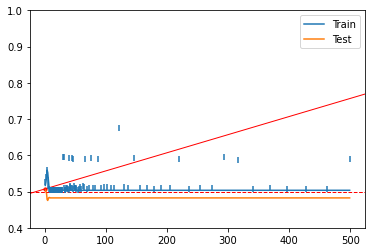

AT (1, 0.5075135015254776, 0.394389198779618) WITH 91 ITERATIONS IN 235.91407779852548 SECONDS : 53.21570974152004
__main__.SVM_RFE_W_STEP - 00:04:21.524196300
rbf 3 0.2


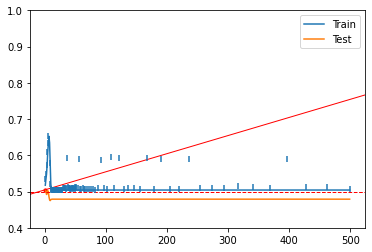

AT (1, 0.5050214885544227, 0.39638280915646185) WITH 91 ITERATIONS IN 225.97755642731985 SECONDS : 20.718783741102158
__main__.SVM_RFE_W_STEP - 00:04:08.211321000
rbf 3 0.3


AT (6, 0.5054905204605804, 0.3980075836315357) WITH 91 ITERATIONS IN 221.42135405540466 SECONDS : 48.34865719651632
__main__.SVM_RFE_W_STEP - 00:04:06.563613500
rbf 3 0.4


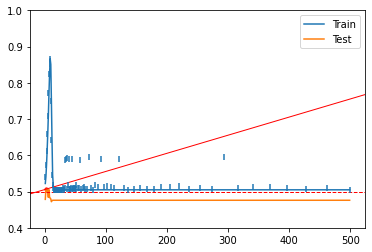

AT (2, 0.506499013984044, 0.3956007888127649) WITH 91 ITERATIONS IN 223.1304950316747 SECONDS : 18.280086459647148
__main__.SVM_RFE_W_STEP - 00:04:06.486654800
rbf 3 0.5


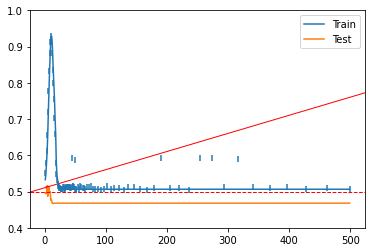

AT (4, 0.5124840409271546, 0.3916127672582763) WITH 91 ITERATIONS IN 224.0050062338511 SECONDS : 24.829279396233698
__main__.SVM_RFE_W_STEP - 00:04:08.264718200
rbf 3 0.6


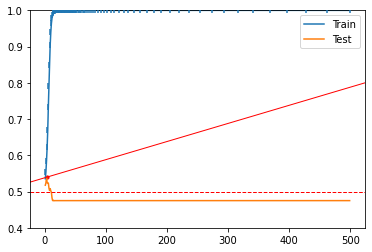

AT (3, 0.5395080709451967, 0.36959354324384264) WITH 91 ITERATIONS IN 223.01632312933603 SECONDS : 19.640416858964468
__main__.SVM_RFE_W_STEP - 00:04:06.820156900
rbf 3 0.7


AT (7, 0.5069890249530967, 0.3972087800375227) WITH 91 ITERATIONS IN 223.19029657046 SECONDS : 23.122410705681503
__main__.SVM_RFE_W_STEP - 00:04:07.129985600
rbf 3 0.8


AT (4, 0.5084995174815534, 0.39480038601475725) WITH 91 ITERATIONS IN 224.34672609965006 SECONDS : 45.189384214522924
__main__.SVM_RFE_W_STEP - 00:04:08.731254600
rbf 3 0.9


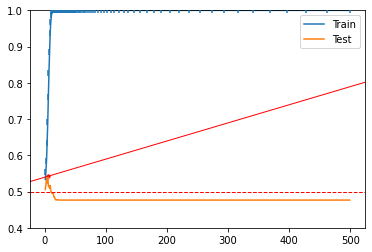

AT (5, 0.5420180659701618, 0.3683855472238706) WITH 91 ITERATIONS IN 226.2864969174067 SECONDS : 49.76476301112402
__main__.SVM_RFE_W_STEP - 00:04:11.956656600
rbf 3 0.1


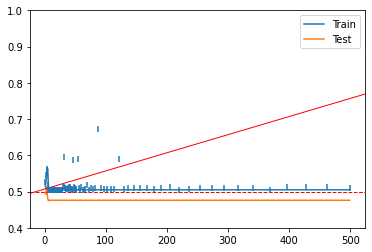

AT (3, 0.5085130040219861, 0.39438959678241114) WITH 91 ITERATIONS IN 227.50442067782083 SECONDS : 26.10275784205244
__main__.SVM_RFE_W_STEP - 00:04:11.945665300
rbf 3 0.2


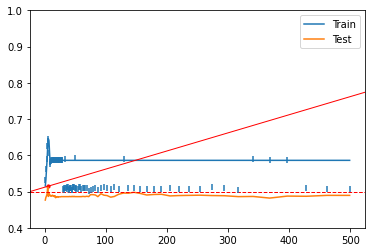

AT (5, 0.5144890399381418, 0.3904087680494866) WITH 91 ITERATIONS IN 234.48512335618338 SECONDS : 22.160544274710173
__main__.SVM_RFE_W_STEP - 00:04:17.287426000
rbf 3 0.3


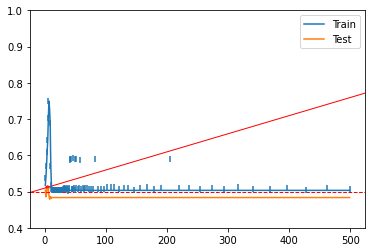

AT (4, 0.5115100130070189, 0.39239198959438487) WITH 91 ITERATIONS IN 228.14981412887573 SECONDS : 41.89772072064901
__main__.SVM_RFE_W_STEP - 00:04:14.018115400
rbf 3 0.4


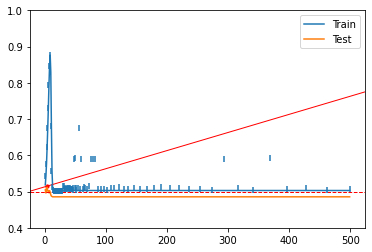

AT (3, 0.5145175115234996, 0.3895859907812004) WITH 91 ITERATIONS IN 230.9843603769938 SECONDS : 29.06673772085502
__main__.SVM_RFE_W_STEP - 00:04:14.052429900
rbf 3 0.5


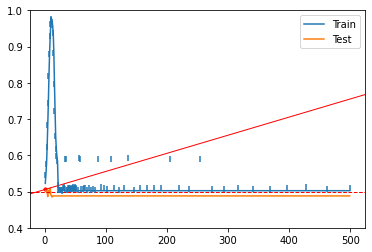

AT (1, 0.5059985134835435, 0.3956011892131652) WITH 91 ITERATIONS IN 225.40732181072235 SECONDS : 38.15232956535663
__main__.SVM_RFE_W_STEP - 00:04:08.746608000
rbf 3 0.6


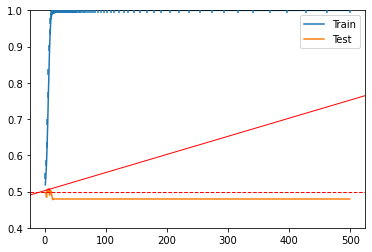

AT (5, 0.5049915184645724, 0.39800678522834215) WITH 91 ITERATIONS IN 233.5691522359848 SECONDS : 26.524808259679855
__main__.SVM_RFE_W_STEP - 00:04:18.936367800
rbf 3 0.7


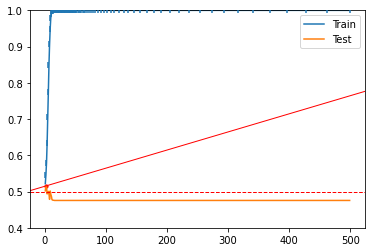

AT (2, 0.5155050259840679, 0.3883959792127457) WITH 91 ITERATIONS IN 226.23687680562338 SECONDS : 22.624531238908876
__main__.SVM_RFE_W_STEP - 00:04:10.502262100
rbf 3 0.8


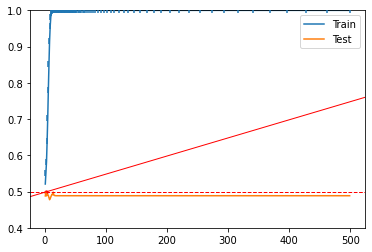

AT (2, 0.4989930049810289, 0.40160559601517687) WITH 91 ITERATIONS IN 229.53407883644104 SECONDS : 59.97956471006139
__main__.SVM_RFE_W_STEP - 00:04:15.583506400
rbf 3 0.9


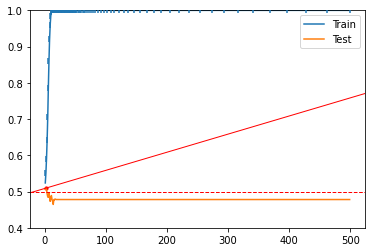

AT (2, 0.5095110080140021, 0.3931911935887984) WITH 91 ITERATIONS IN 226.33335753281912 SECONDS : 67.50310658922918
__main__.SVM_RFE_W_STEP - 00:04:14.826377500


In [14]:
model_selection = {}
for gamma in [0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    for C in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        model_selection[C, gamma] = SVM_RFE_W_STEP(20, C, gamma=gamma, kernel='rbf', sampling_p=0.6, dstep_p=0.08, dstop = 30)

In [20]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + str(C) + '}', '', '', '']

for C, d in model_selection:
    col = {0.5: 1, 0.6: 2, 0.7: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[0][2])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.1} &     1 & 50.75\% & 0.394 &     3 & 50.85\% & 0.394 & \\
\textbf{0.2} &     1 & 50.50\% & 0.396 &     5 & 51.45\% & 0.390 & \\
\textbf{0.3} &     6 & 50.55\% & 0.398 &     4 & 51.15\% & 0.392 & \\
\textbf{0.4} &     2 & 50.65\% & 0.396 &     3 & 51.45\% & 0.390 & \\
\textbf{0.5} &     4 & 51.25\% & 0.392 &     1 & 50.60\% & 0.396 & \\
\textbf{0.6} &     3 & 53.95\% & 0.370 &     5 & 50.50\% & 0.398 & \\
\textbf{0.7} &     7 & 50.70\% & 0.397 &     2 & 51.55\% & 0.388 & \\
\textbf{0.8} &     4 & 50.85\% & 0.395 &     2 & 49.90\% & 0.402 & \\
\textbf{0.9} &     5 & 54.20\% & 0.368 &     2 & 50.95\% & 0.393 & \\


In [22]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + str(C) + '}', '', '', '', '', '', '', '', '', '']

for C, d in model_selection:
    col = {0.025: 1, 0.05: 2, 0.1: 3, 0.2: 4, 0.3: 5, 0.4: 6, 0.5: 7, 0.6: 8, 0.7: 9}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}".format(v[1]/60, str(int(v[1] % 60)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.1} & 4:34 & 4:57 & 4:56 & 4:50 & 4:36 & 4:00 & 4:55 & 4:47 & \\
\textbf{0.2} & 4:50 & 4:57 & 4:45 & 4:48 & 4:34 & 4:53 & 4:45 & 4:54 & \\
\textbf{0.3} & 4:48 & 4:58 & 4:43 & 4:49 & 4:44 & 4:48 & 4:41 & 4:48 & \\
\textbf{0.4} & 4:50 & 4:30 & 4:49 & 4:46 & 4:46 & 4:48 & 4:43 & 4:50 & \\
\textbf{0.5} & 4:50 & 4:30 & 4:42 & 4:40 & 4:41 & 4:50 & 4:44 & 4:45 & \\
\textbf{0.6} & 4:46 & 4:47 & 4:47 & 4:38 & 4:52 & 4:58 & 4:43 & 4:53 & \\
\textbf{0.7} & 4:53 & 4:53 & 4:46 & 4:35 & 4:48 & 4:53 & 4:43 & 4:46 & \\
\textbf{0.8} & 4:46 & 4:46 & 4:51 & 4:33 & 4:51 & 4:50 & 4:44 & 4:49 & \\
\textbf{0.9} & 4:43 & 4:43 & 4:56 & 4:34 & 4:59 & 4:52 & 4:46 & 4:46 & \\


rbf 3 5


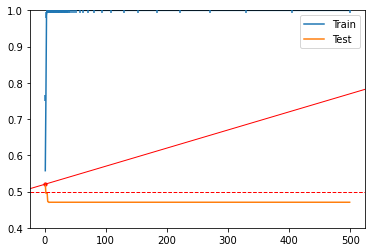

AT (1, 0.5204950459441476, 0.38400396324468195) WITH 57 ITERATIONS IN 138.09604581197104 SECONDS : 57.40551553156877
__main__.SVM_RFE_W_STEP - 00:02:44.627492600
rbf 3 0.5


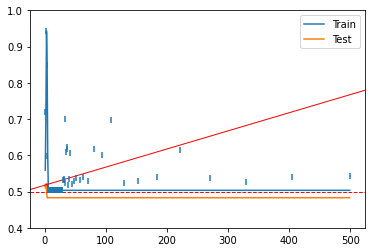

AT (2, 0.5185005364646084, 0.3859995708283134) WITH 57 ITERATIONS IN 145.63028927644095 SECONDS : 0.7095259412321377
__main__.SVM_RFE_W_STEP - 00:02:49.253586000
rbf 3 0.1


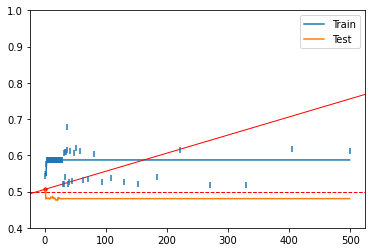

AT (1, 0.5064945184705664, 0.39520438522354695) WITH 57 ITERATIONS IN 144.8084068695704 SECONDS : 0.5815523959734304
__main__.SVM_RFE_W_STEP - 00:02:48.364399000


((1, 0.5064945184705664, 0.39520438522354695), 144.8084068695704)

In [26]:
SVM_RFE_W_STEP(20, 5, gamma=50, kernel='rbf', sampling_p=0.1, dstep_p=0.2, dstop = 30)
SVM_RFE_W_STEP(20, 0.5, gamma=50, kernel='rbf', sampling_p=0.1, dstep_p=0.2, dstop = 30)
SVM_RFE_W_STEP(20, 0.1, gamma=50, kernel='rbf', sampling_p=0.1, dstep_p=0.2, dstop = 30)

rbf 3 1


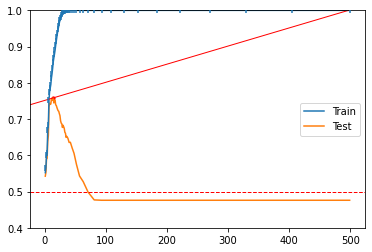

AT (13, 0.7579840319361276, 0.19881277445109793) WITH 57 ITERATIONS IN 124.15494879086812 SECONDS : 18.600520779846548
__main__.SVM_RFE_W_STEP - 00:02:20.770551000
rbf 3 2


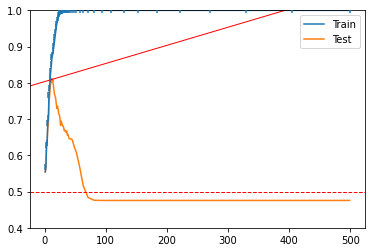

AT (11, 0.8089706472940007, 0.15722348216479945) WITH 57 ITERATIONS IN 125.07059756914775 SECONDS : 53.83990249520945
__main__.SVM_RFE_W_STEP - 00:02:22.038679200


((11, 0.8089706472940007, 0.15722348216479945), 125.07059756914775)

In [28]:
SVM_RFE_W_STEP(20, 1, gamma=0.1, kernel='rbf', sampling_p=0.6, dstep_p=0.2, dstop = 30)
SVM_RFE_W_STEP(20, 2, gamma=0.1, kernel='rbf', sampling_p=0.6, dstep_p=0.2, dstop = 30)

In [29]:
SVM_RFE_W_STEP(20, 5, gamma=0.1, kernel='rbf', sampling_p=0.6, dstep_p=0.2, dstop = 30)

rbf 3 5


AT (11, 0.7784281287275299, 0.1816574970179761) WITH 57 ITERATIONS IN 127.38928333918254 SECONDS : 9.87109758953302
__main__.SVM_RFE_W_STEP - 00:02:23.803230700


((11, 0.7784281287275299, 0.1816574970179761), 127.38928333918254)

rbf 3 0.0005


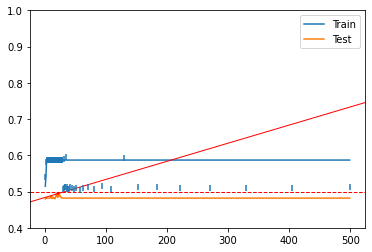

AT (20, 0.4934620248991506, 0.4132303800806796) WITH 57 ITERATIONS IN 384.4136670033137 SECONDS : 17.15890490551818
__main__.SVM_RFE_W_STEP - 00:06:49.260807400


((20, 0.4934620248991506, 0.4132303800806796), 384.4136670033137)

In [30]:
SVM_RFE_W_STEP(20, 0.0005, gamma=50, kernel='rbf', sampling_p=0.6, dstep_p=0.2, dstop = 30)

In [ ]:
SVM_RFE_W_STEP(20, 0.9999, gamma=50, kernel='rbf', sampling_p=0.6, dstep_p=0.2, dstop = 30)